In [18]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score,precision_score, recall_score, confusion_matrix,roc_auc_score
# pipeline
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from gensim.models import Word2Vec
import optuna
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
random_state = 42
# set random state
np.random.seed(random_state)


In [19]:
# loading data
data = pd.read_csv('data/XSS_dataset.csv')
data.head()

,Unnamed: 0,Sentence,Label
0,0,"<li><a href=""/wiki/File:Socrates.png"" class=""i...",0
1,1,"<tt onmouseover=""alert(1)"">test</tt>",1
2,2,"\t </span> <span class=""reference-text"">Steeri...",0
3,3,"\t </span> <span class=""reference-text""><cite ...",0
4,4,"\t </span>. <a href=""/wiki/Digital_object_iden...",0


In [20]:
# remove unnamed column
col_to_remove = 'Unnamed: 0'
data = data.drop(col_to_remove, axis=1)
data.head()

,Sentence,Label
0,"<li><a href=""/wiki/File:Socrates.png"" class=""i...",0
1,"<tt onmouseover=""alert(1)"">test</tt>",1
2,"\t </span> <span class=""reference-text"">Steeri...",0
3,"\t </span> <span class=""reference-text""><cite ...",0
4,"\t </span>. <a href=""/wiki/Digital_object_iden...",0


In [21]:
print("total number of samples: ", len(data))

total number of samples:  13686


In [22]:
data['Sentence'][0]

'<li><a href="/wiki/File:Socrates.png" class="image"><img alt="Socrates.png" src="//upload.wikimedia.org/wikipedia/commons/thumb/c/cd/Socrates.png/18px-Socrates.png" decoding="async" width="18" height="28" class="noviewer" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/c/cd/Socrates.png/27px-Socrates.png 1.5x, //upload.wikimedia.org/wikipedia/commons/thumb/c/cd/Socrates.png/36px-Socrates.png 2x" data-file-width="326" data-file-height="500" /> </a> <a href="/wiki/Portal:Philosophy" title="Portal:Philosophy">Philosophy&#32;portal </a> </li> </ul>'

<AxesSubplot:ylabel='Label'>

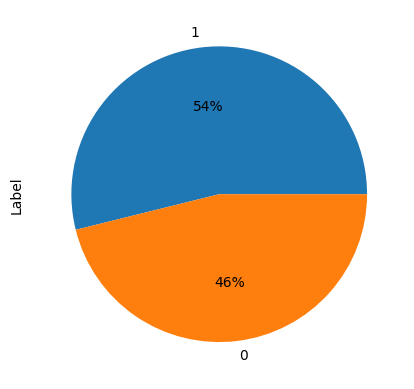

In [23]:
# pie chart for label
data['Label'].value_counts().plot(kind='pie', autopct='%1.0f%%')

In [24]:
# preprocessing the data and adding more features
# influenced from https://ieeexplore.ieee.org/abstract/document/9270052 and word2vec as suggested in https://isi.jhu.edu/wp-content/uploads/2020/04/HICSS19-XSS-Analysis-hicss-draft-9-22-2018-V3.pdf
def feature_engineering(dataset: pd.DataFrame) -> pd.DataFrame:
    # Number of characters
    dataset['num_characters'] = dataset['Sentence'].apply(lambda x: len(x))
    
    # Presence of doubled characters
    dataset['doubled_characters'] = dataset['Sentence'].apply(lambda x: any(x[i] == x[i+1] for i in range(len(x)-1)))
    
    # Presence of special characters
    special_characters = ['<', '>', '/', '\\', '{', '}', '[', ']', '(', ')', '*', '&', '^', '%', '$', '#', '@', '!', '~']
    dataset['special_characters'] = dataset['Sentence'].apply(lambda x: any(c in special_characters for c in x))
    
    # content-length
    dataset['content_length'] = dataset['Sentence'].apply(lambda x: len(x))
    
    # Number of keywords
    keywords = ['signup', 'login', 'contact', 'search']
    dataset['num_keywords'] = dataset['Sentence'].apply(lambda x: sum(kw in x for kw in keywords))
    
    # Script-tags
    dataset['script_tags'] = dataset['Sentence'].apply(lambda x: '<script' in x or '</script>' in x)
    
    # Presence of cookies
    dataset['cookies'] = dataset['Sentence'].apply(lambda x: 'cookie' in x)
    
    # Word2vec features
    sentences = [list(s) for s in dataset['Sentence']]
    model = Word2Vec(sentences, min_count=1, vector_size=50)
    
    def get_word2vec_features(sentence):
        vectors = [model.wv[c] for c in sentence if c in model.wv]
        if not vectors:
            return [0] * model.vector_size
        return list(sum(vectors) / len(vectors))
    
    word2vec_features = pd.DataFrame(dataset['Sentence'].apply(get_word2vec_features).tolist())
    word2vec_features.columns = [f'word2vec_{i}' for i in range(model.vector_size)]
    
    return pd.concat([dataset, word2vec_features], axis=1)

df = data.copy()
df = feature_engineering(df)

In [25]:
# drop the sentence column
df = df.drop(['Sentence'], axis=1)
X = df.drop(['Label'], axis=1)
y = df['Label']
df.head()

,Label,num_characters,doubled_characters,special_characters,content_length,num_keywords,script_tags,cookies,word2vec_0,word2vec_1,...,word2vec_40,word2vec_41,word2vec_42,word2vec_43,word2vec_44,word2vec_45,word2vec_46,word2vec_47,word2vec_48,word2vec_49
0,0,557,True,True,557,0,False,False,-0.207332,-0.146628,...,-0.328812,0.547116,0.349720,0.070716,0.376804,-0.252959,0.178369,-0.107973,-0.386612,-0.100054
1,1,36,True,True,36,0,False,False,-0.519252,-0.440489,...,-0.449003,-0.006960,-0.085172,-0.165305,0.244060,-0.521356,-0.274165,0.229108,-0.123470,-0.497395
2,0,233,True,True,233,0,False,False,-0.165519,-0.214986,...,-0.517975,0.287183,0.111894,-0.103683,0.274325,-0.289076,-0.091516,-0.052000,-0.184442,-0.297651
3,0,395,True,True,395,0,False,False,-0.206685,-0.251748,...,-0.421507,0.411727,0.169778,0.047744,0.417386,-0.394629,-0.081718,-0.085480,-0.150681,-0.287796
4,0,422,True,True,422,0,False,False,-0.121594,-0.286606,...,-0.339744,0.434240,-0.033923,-0.062052,0.023198,0.058819,0.191581,0.040920,-0.161448,-0.247162


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
# hyperparameter tuning using optuna
# function to tune hyperparameters using optuna
def tune_model(model_class, X_train, y_train, model_name, parameter, k,trials=10):
    # define the objective function
    def objective(trial):
        # sample hyperparameters from parameter argument
        params = {}
        for key, value in parameter.items():
            if isinstance(value, list):
                params[key] = trial.suggest_categorical(key, value)
            elif isinstance(value, tuple):
                if value[0] == 'int':
                    params[key] = trial.suggest_int(key, value[1], value[2])
                elif value[0] == 'float':
                    params[key] = trial.suggest_float(key, value[1], value[2])
                else:
                    raise ValueError('Invalid parameter type')
            else:
                raise ValueError('Invalid parameter format')
        
        # use k fold cross validation
        kf = KFold(n_splits=k, shuffle=True, random_state=random_state)
        scores = []
        for train_index, test_index in kf.split(y_train):
            X_tra, X_tes = X_train.iloc[train_index], X_train.iloc[test_index]
            y_tra, y_tes = y_train.iloc[train_index], y_train.iloc[test_index]
            
            # train the model
            model = model_class(**params)

            model.fit(X_tra, y_tra)
            
            # predict and evaluate on test set
            pred = model.predict(X_tes)
            score = f1_score(y_tes, pred, average='weighted')
            scores.append(score)
        
        # return the negative average f1 score as the objective value
        return -np.mean(scores)
    
    # create a study object and optimize the objective function
    study = optuna.create_study()
    study.optimize(objective, n_trials=trials)
    
    # return the best parameters and the best score
    return study.best_params, -study.best_value


In [28]:
# defining 10 different models
models = []
models.append(('LR', LogisticRegression(random_state=random_state)))
models.append(('DT', DecisionTreeClassifier(random_state=random_state)))
models.append(('RF', RandomForestClassifier(random_state=random_state)))
models.append(('SVM', SVC(random_state=random_state)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('GB', GradientBoostingClassifier(random_state=random_state)))
models.append(('AB', AdaBoostClassifier(random_state=random_state)))
models.append(('MLP', MLPClassifier(hidden_layer_sizes=(20,10), random_state=random_state)))
models.append(('CB', CatBoostClassifier(logging_level='Silent', random_state=random_state, thread_count=-1)))
models.append(('LGBM', LGBMClassifier(random_state=random_state, n_jobs=-1)))

In [29]:
import optuna
# define the parameters for each model
parameters = {}
parameters['LR'] = {'penalty':['l2'], 'C': ('float', 0.01, 10.0), 'solver': ['lbfgs', 'liblinear']}
parameters['DT'] = {'criterion': ['gini', 'entropy'], 'max_depth': ('int', 2, 20), 'min_samples_split': ('int', 2, 10), 'min_samples_leaf': ('int', 1, 10)}
parameters['RF'] = {'n_estimators': ('int', 10, 100), 'criterion': ['gini', 'entropy'], 'max_depth': ('int', 2, 20), 'min_samples_split': ('int', 2, 10), 'min_samples_leaf': ('int', 1, 10),'n_jobs': [-1]}
parameters['SVM'] = {'kernel': ['linear', 'rbf'], 'C': ('float', 1, 10.0), 'gamma': ('float', 1e-4, 1e-1)}
parameters['KNN'] = {'n_neighbors': ('int', 1, 8), 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan', 'minkowski']}
parameters['GB'] = {'n_estimators': ('int', 10,150), 'learning_rate': ('float', 1e-4, 1e-1), 'subsample': ('float', 0.4, 1.0), 'max_depth': ('int', 2, 6), 'min_samples_split': ('int', 2, 10), 'min_samples_leaf': ('int', 1, 10)}
parameters['AB'] = {'n_estimators': ('int', 10, 50), 'learning_rate': ('float', 1e-4, 1e-1)}
parameters['MLP'] = {'activation': ['logistic', 'relu'], 'solver': ['sgd', 'adam'], 'alpha': ('float', 1e-8, 10.0), 'learning_rate_init': ('float', 1e-4, 1e-1)}
parameters['CB'] = {'iterations': ('int', 10, 150), 'learning_rate': ('float', 1e-4, 1e-1),  'l2_leaf_reg': ('float', 1e-8, 10.0), 'verbose': [False]}
parameters['LGBM'] = {'num_leaves': ('int', 2, 256), 'learning_rate': ('float', 1e-4, 1e-1), 'colsample_bytree': ('float', 0.4, 1.0), 'subsample': ('float', 0.4, 1.0), 'subsample_freq': ('int', 1, 7), 'reg_alpha': ('float', 1e-8, 10.0), 'reg_lambda': ('float', 1e-8, 10.0), 'n_jobs': [-1], 'verbose': [-1]}


# tune each model using the tune_model function
results = {}


In [30]:
logreg = models[0][1].__class__
best_params, best_score = tune_model(logreg, X_train, y_train, "LR", parameters["LR"], k=5)
print("Best parameters: ", best_params)
print("Best score: ", best_score)

[I 2023-09-02 12:08:20,127] A new study created in memory with name: no-name-7030abf7-8845-4894-999e-2554c070a5d1
[I 2023-09-02 12:08:21,712] Trial 0 finished with value: -0.9943367561078608 and parameters: {'penalty': 'l2', 'C': 7.324023190843915, 'solver': 'liblinear'}. Best is trial 0 with value: -0.9943367561078608.
[I 2023-09-02 12:08:22,847] Trial 1 finished with value: -0.994154215393172 and parameters: {'penalty': 'l2', 'C': 7.904516398490127, 'solver': 'liblinear'}. Best is trial 0 with value: -0.9943367561078608.
[I 2023-09-02 12:08:23,841] Trial 2 finished with value: -0.993606238860471 and parameters: {'penalty': 'l2', 'C': 2.187014065966645, 'solver': 'liblinear'}. Best is trial 0 with value: -0.9943367561078608.
[I 2023-09-02 12:08:24,942] Trial 3 finished with value: -0.9941540177329449 and parameters: {'penalty': 'l2', 'C': 6.707513153640988, 'solver': 'liblinear'}. Best is trial 0 with value: -0.9943367561078608.
[I 2023-09-02 12:08:25,801] Trial 4 finished with value:

Best parameters:  {'penalty': 'l2', 'C': 7.324023190843915, 'solver': 'liblinear'}
Best score:  0.9943367561078608


In [27]:
decision_tree = models[1][1].__class__
best_params, best_score = tune_model(decision_tree, X_train, y_train, "DT", parameters["DT"], k=5)
print("Best parameters: ", best_params)
print("Best score: ", best_score)

[I 2023-08-24 18:05:49,042] A new study created in memory with name: no-name-3693411a-3a7a-4d0b-93aa-5970e4adb454
[I 2023-08-24 18:05:49,532] Trial 0 finished with value: -0.9810134919974051 and parameters: {'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 0 with value: -0.9810134919974051.
[I 2023-08-24 18:05:50,732] Trial 1 finished with value: -0.9914159043408114 and parameters: {'criterion': 'entropy', 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 1 with value: -0.9914159043408114.
[I 2023-08-24 18:05:51,887] Trial 2 finished with value: -0.99041164661876 and parameters: {'criterion': 'entropy', 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 6}. Best is trial 1 with value: -0.9914159043408114.
[I 2023-08-24 18:05:52,414] Trial 3 finished with value: -0.9836587106474891 and parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 6}. Best is trial 1 w

Best parameters:  {'criterion': 'entropy', 'max_depth': 19, 'min_samples_split': 6, 'min_samples_leaf': 2}
Best score:  0.9916897355482444


In [31]:
random_forest = models[2][1].__class__
best_params, best_score = tune_model(random_forest, X_train, y_train, "RF", parameters["RF"], k=5)
print("Best parameters: ", best_params)
print("Best score: ", best_score)

[I 2023-09-02 12:08:37,228] A new study created in memory with name: no-name-7096c381-1e52-4d7e-a3ae-9b34a1145b10
[I 2023-09-02 12:08:39,873] Trial 0 finished with value: -0.9944297146548269 and parameters: {'n_estimators': 41, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1, 'n_jobs': -1}. Best is trial 0 with value: -0.9944297146548269.
[I 2023-09-02 12:08:44,429] Trial 1 finished with value: -0.9954337856926028 and parameters: {'n_estimators': 83, 'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 2, 'n_jobs': -1}. Best is trial 1 with value: -0.9954337856926028.
[I 2023-09-02 12:08:45,463] Trial 2 finished with value: -0.9894994488011333 and parameters: {'n_estimators': 16, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 3, 'n_jobs': -1}. Best is trial 1 with value: -0.9954337856926028.
[I 2023-09-02 12:08:49,611] Trial 3 finished with value: -0.9937898301305736 and parameters: {'n

Best parameters:  {'n_estimators': 49, 'criterion': 'gini', 'max_depth': 18, 'min_samples_split': 6, 'min_samples_leaf': 1, 'n_jobs': -1}
Best score:  0.9960727640906804


In [32]:
svm = models[3][1].__class__
best_params, best_score = tune_model(svm, X_train, y_train, "SVM", parameters["SVM"], k=5)
print("Best parameters: ", best_params)
print("Best score: ", best_score)

[I 2023-09-02 12:10:17,498] A new study created in memory with name: no-name-8d65c3ee-b410-4470-95b9-f0242a87abf5
[I 2023-09-02 12:16:40,292] Trial 0 finished with value: -0.9954330207223165 and parameters: {'kernel': 'linear', 'C': 5.618907011055436, 'gamma': 0.0968722981013086}. Best is trial 0 with value: -0.9954330207223165.
[I 2023-09-02 12:16:47,135] Trial 1 finished with value: -0.9942474378484375 and parameters: {'kernel': 'rbf', 'C': 8.57572539232995, 'gamma': 0.053788173950030146}. Best is trial 0 with value: -0.9954330207223165.
[I 2023-09-02 12:25:53,276] Trial 2 finished with value: -0.9954330207223165 and parameters: {'kernel': 'linear', 'C': 5.174058982851096, 'gamma': 0.0914635952032715}. Best is trial 0 with value: -0.9954330207223165.
[I 2023-09-02 12:32:43,489] Trial 3 finished with value: -0.9954330207223165 and parameters: {'kernel': 'linear', 'C': 5.350338050711112, 'gamma': 0.025374258752290223}. Best is trial 0 with value: -0.9954330207223165.
[I 2023-09-02 12:3

Best parameters:  {'kernel': 'linear', 'C': 5.618907011055436, 'gamma': 0.0968722981013086}
Best score:  0.9954330207223165


In [31]:
knn = models[4][1].__class__
best_params, best_score = tune_model(knn, X_train, y_train, "KNN", parameters["KNN"], k=5)
print("Best parameters: ", best_params)
print("Best score: ", best_score)

[I 2023-08-24 19:38:06,608] A new study created in memory with name: no-name-fd4b24ae-a3f1-4446-88eb-a21235f5cbeb
[I 2023-08-24 19:38:07,811] Trial 0 finished with value: -0.9880359343856877 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 0 with value: -0.9880359343856877.
[I 2023-08-24 19:38:08,832] Trial 1 finished with value: -0.9708435972928283 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 0 with value: -0.9880359343856877.
[I 2023-08-24 19:38:09,478] Trial 2 finished with value: -0.9799904736926756 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 0 with value: -0.9880359343856877.
[I 2023-08-24 19:38:13,602] Trial 3 finished with value: -0.9891319325139486 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 3 with value: -0.9891319325139486.
[I 2023-08-24 19:38:17,232] Trial 4 finished with value:

Best parameters:  {'n_neighbors': 2, 'weights': 'distance', 'metric': 'manhattan'}
Best score:  0.9924196891377243


In [32]:
gradient_boosting = models[5][1].__class__
best_params, best_score = tune_model(gradient_boosting, X_train, y_train, "GB", parameters["GB"], k=5)
print("Best parameters: ", best_params)
print("Best score: ", best_score)


[I 2023-08-24 19:38:37,282] A new study created in memory with name: no-name-fcdea3a9-09f1-4d21-9109-a974e5cf03e1
[I 2023-08-24 19:39:48,824] Trial 0 finished with value: -0.9905962323845046 and parameters: {'n_estimators': 126, 'learning_rate': 0.013547748252091827, 'subsample': 0.8845009959320108, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 5}. Best is trial 0 with value: -0.9905962323845046.
[I 2023-08-24 19:40:01,291] Trial 1 finished with value: -0.9923291667856967 and parameters: {'n_estimators': 38, 'learning_rate': 0.0776891056102944, 'subsample': 0.4002693057607967, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 9}. Best is trial 1 with value: -0.9923291667856967.
[I 2023-08-24 19:40:48,244] Trial 2 finished with value: -0.9909598868681048 and parameters: {'n_estimators': 133, 'learning_rate': 0.03664980533571439, 'subsample': 0.7825815257950312, 'max_depth': 2, 'min_samples_split': 5, 'min_samples_leaf': 9}. Best is trial 1 with value: -0.99232916

Best parameters:  {'n_estimators': 124, 'learning_rate': 0.08942180616541094, 'subsample': 0.7662654523104089, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 8}
Best score:  0.9960726894454384


In [33]:
adaboost = models[6][1].__class__
best_params, best_score = tune_model(adaboost, X_train, y_train, "AB", parameters["AB"], k=5)
print("Best parameters: ", best_params)
print("Best score: ", best_score)

[I 2023-08-24 19:46:46,936] A new study created in memory with name: no-name-24fe055e-a97a-48e2-8225-489fbf5407a8
[I 2023-08-24 19:46:58,624] Trial 0 finished with value: -0.9717698438615867 and parameters: {'n_estimators': 41, 'learning_rate': 0.030229363513724797}. Best is trial 0 with value: -0.9717698438615867.
[I 2023-08-24 19:47:07,604] Trial 1 finished with value: -0.9761522407183234 and parameters: {'n_estimators': 31, 'learning_rate': 0.052213845302700214}. Best is trial 1 with value: -0.9761522407183234.
[I 2023-08-24 19:47:16,385] Trial 2 finished with value: -0.971160450052829 and parameters: {'n_estimators': 29, 'learning_rate': 0.021417355542364406}. Best is trial 1 with value: -0.9761522407183234.
[I 2023-08-24 19:47:27,140] Trial 3 finished with value: -0.9757866139610325 and parameters: {'n_estimators': 39, 'learning_rate': 0.041871484004951866}. Best is trial 1 with value: -0.9761522407183234.
[I 2023-08-24 19:47:36,807] Trial 4 finished with value: -0.982556421873093

Best parameters:  {'n_estimators': 44, 'learning_rate': 0.09940802079742721}
Best score:  0.9845675978359599


In [34]:
mlp = models[7][1].__class__
best_params, best_score = tune_model(mlp, X_train, y_train, "MLP", parameters["MLP"], k=5)
print("Best parameters: ", best_params)
print("Best score: ", best_score)

[I 2023-08-24 19:53:58,718] A new study created in memory with name: no-name-881fd296-2b01-4d3c-ad4d-fff16f280f12
[I 2023-08-24 19:54:02,838] Trial 0 finished with value: -0.5368759044912753 and parameters: {'activation': 'logistic', 'solver': 'adam', 'alpha': 1.3129380165643219, 'learning_rate_init': 0.09003516427393289}. Best is trial 0 with value: -0.5368759044912753.
[I 2023-08-24 19:54:19,137] Trial 1 finished with value: -0.9812878554651027 and parameters: {'activation': 'relu', 'solver': 'adam', 'alpha': 5.828344153638823, 'learning_rate_init': 0.0009386837969320477}. Best is trial 1 with value: -0.9812878554651027.
[I 2023-08-24 19:54:30,971] Trial 2 finished with value: -0.5984611759190377 and parameters: {'activation': 'logistic', 'solver': 'sgd', 'alpha': 6.926861722657606, 'learning_rate_init': 0.08708897276693751}. Best is trial 1 with value: -0.9812878554651027.
[I 2023-08-24 19:54:36,011] Trial 3 finished with value: -0.47835671524314166 and parameters: {'activation': 'l

Best parameters:  {'activation': 'relu', 'solver': 'adam', 'alpha': 1.1506751776413437, 'learning_rate_init': 0.009204994576450012}
Best score:  0.9905019501068104


In [33]:
catboost = models[8][1].__class__
best_params, best_score = tune_model(catboost, X_train, y_train, "CB", parameters["CB"], k=5)
print("Best parameters: ", best_params)
print("Best score: ", best_score)

[I 2023-09-02 16:10:50,861] A new study created in memory with name: no-name-cb272306-ee13-4584-a0a4-f97f6ccb5b1d
[I 2023-09-02 16:10:53,019] Trial 0 finished with value: -0.9938805362563501 and parameters: {'iterations': 70, 'learning_rate': 0.051803775594034984, 'l2_leaf_reg': 4.280583132767183, 'verbose': False}. Best is trial 0 with value: -0.9938805362563501.
[I 2023-09-02 16:10:53,642] Trial 1 finished with value: -0.9902281825364654 and parameters: {'iterations': 16, 'learning_rate': 0.051714742956592404, 'l2_leaf_reg': 3.9965877966282757, 'verbose': False}. Best is trial 0 with value: -0.9938805362563501.
[I 2023-09-02 16:10:56,679] Trial 2 finished with value: -0.9948853725443316 and parameters: {'iterations': 112, 'learning_rate': 0.051976365852249844, 'l2_leaf_reg': 5.185846793398808, 'verbose': False}. Best is trial 2 with value: -0.9948853725443316.
[I 2023-09-02 16:10:58,472] Trial 3 finished with value: -0.9877614478505816 and parameters: {'iterations': 62, 'learning_rat

Best parameters:  {'iterations': 85, 'learning_rate': 0.07825322989722981, 'l2_leaf_reg': 3.0414487841929865, 'verbose': False}
Best score:  0.9956159194733358


In [34]:
lgbm = models[9][1].__class__
best_params, best_score = tune_model(lgbm, X_train, y_train, "LGBM", parameters["LGBM"], k=5)
print("Best parameters: ", best_params)
print("Best score: ", best_score)

[I 2023-09-02 16:18:00,378] A new study created in memory with name: no-name-d03e51a3-61a1-4b7d-bdc6-8b7b67abfe9a
[I 2023-09-02 16:18:01,054] Trial 0 finished with value: -0.9929672629133528 and parameters: {'num_leaves': 89, 'learning_rate': 0.06862005413251294, 'colsample_bytree': 0.8673849366375331, 'subsample': 0.6104242166585201, 'subsample_freq': 6, 'reg_alpha': 9.349714132926255, 'reg_lambda': 9.322360357338194, 'n_jobs': -1, 'verbose': -1}. Best is trial 0 with value: -0.9929672629133528.
[I 2023-09-02 16:18:01,736] Trial 1 finished with value: -0.9936983127997647 and parameters: {'num_leaves': 203, 'learning_rate': 0.055868101073013834, 'colsample_bytree': 0.603222468717984, 'subsample': 0.7072143084065972, 'subsample_freq': 2, 'reg_alpha': 7.236158183858153, 'reg_lambda': 1.1056420931434887, 'n_jobs': -1, 'verbose': -1}. Best is trial 1 with value: -0.9936983127997647.
[I 2023-09-02 16:18:02,198] Trial 2 finished with value: -0.9918722040819118 and parameters: {'num_leaves': 

Best parameters:  {'num_leaves': 250, 'learning_rate': 0.09837676287415487, 'colsample_bytree': 0.48697618035029516, 'subsample': 0.8292154445933932, 'subsample_freq': 4, 'reg_alpha': 4.511343316528328, 'reg_lambda': 2.605588011575658, 'n_jobs': -1, 'verbose': -1}
Best score:  0.9950680360097787


In [22]:
# function to test different models using the best parameters
def test_model(model_class, X_train, y_train, X_test, y_test, model_name, best_params):
    # set the model parameters to the best ones
    model = model_class(**best_params)    
    # fit the model on the train set
    model.fit(X_train, y_train)

    # predict and evaluate on the test set
    pred = model.predict(X_test)

    # calculate accuracy
    score = accuracy_score(y_test, pred)

    # calculate f1 score
    f1 = f1_score(y_test, pred, average='weighted')

    # calculate precision
    precision = precision_score(y_test, pred, average='weighted')

    # calculate recall
    recall = recall_score(y_test, pred, average='weighted')

    # calculate confusion matrix
    cm = confusion_matrix(y_test, pred)
  
    # calculate roc auc score
    roc_auc = roc_auc_score(y_test, pred)

    # return all metrics
    return score, f1, precision, recall, cm, roc_auc,model

    

In [25]:
df = pd.DataFrame(columns=['model', 'accuracy', 'f1', 'precision', 'recall', 'specificity', 'sensitivity', 'roc_auc', 'cm'])
best_params = {}
best_params["LR"] = {'penalty': 'l2', 'C': 9.237343450463149, 'solver': 'liblinear'}
best_params["DT"] =   {'criterion': 'entropy', 'max_depth': 18, 'min_samples_split': 8, 'min_samples_leaf': 4}
best_params["SVM"] =  {'kernel': 'linear', 'C': 6.072325341490034, 'gamma': 0.03169530704200389,'random_state': 42}
best_params["RF"] =  {'n_estimators': 43, 'criterion': 'gini', 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'n_jobs': -1}

best_params["KNN"] = {'n_neighbors': 4, 'weights': 'distance', 'metric': 'manhattan'}
best_params["MLP"] = {'activation': 'relu', 'solver': 'adam', 'alpha': 0.26133682036320377, 'learning_rate_init': 0.036337908752116156}
best_params["GB"] = {'n_estimators': 148, 'learning_rate': 0.05954721899653961, 'subsample': 0.5845888910424589, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 2}
best_params["AB"] = {'n_estimators': 39, 'learning_rate': 0.09834157052470563}
best_params["LGBM"] = {'num_leaves': 98, 'learning_rate': 0.07065403635445651, 'colsample_bytree': 0.8999631895955248, 'subsample': 0.8573313782213396, 'subsample_freq': 3, 'reg_alpha': 4.249155539863275, 'reg_lambda': 0.14380522744099736, 'n_jobs': -1, 'verbose': -1}
best_params["CB"] =   {'iterations': 147, 'learning_rate': 0.06128074885165292, 'l2_leaf_reg': 1.2442246935316894, 'verbose': False}
# loop over the models list
for name, model in models:
    # get the best parameters for the current model
    best_params_ = best_params[name]
    
    # test the model using the best parameters
    score, f1, precision, recall, cm, roc_auc,model = test_model(model.__class__, X_train, y_train, X_test, y_test, name, best_params_)
    
    # calculate specificity and sensitivity from the confusion matrix
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)
    
    # append the metrics to the dataframe
    df = pd.concat([df, pd.DataFrame({'model': [model],
                                  'accuracy': [score],
                                  'f1': [f1],
                                  'precision': [precision],
                                  'recall': [recall],
                                  'specificity': [specificity],
                                  'sensitivity': [sensitivity],
                                  'roc_auc': [roc_auc],
                                    'cm': [cm]})], ignore_index=True)
                               


In [27]:
score_df = df.drop(['cm'], axis=1)
# replace model with model.__name__
score_df['model'] = score_df['model'].apply(lambda x: x.__class__.__name__)
score_df

,model,accuracy,f1,precision,recall,specificity,sensitivity,roc_auc
0,LogisticRegression,0.996713,0.996713,0.996713,0.996713,0.996032,0.997294,0.996663
1,DecisionTreeClassifier,0.995982,0.995982,0.995983,0.995982,0.995238,0.996617,0.995928
2,RandomForestClassifier,0.998174,0.998174,0.998177,0.998174,0.999206,0.997294,0.998250
3,SVC,0.996713,0.996713,0.996715,0.996713,0.995238,0.997970,0.996604
4,KNeighborsClassifier,0.994156,0.994157,0.994158,0.994156,0.994444,0.993911,0.994178
5,GradientBoostingClassifier,0.997078,0.997079,0.997089,0.997078,0.999206,0.995264,0.997235
6,AdaBoostClassifier,0.992695,0.992695,0.992695,0.992695,0.992063,0.993234,0.992649
7,MLPClassifier,0.990869,0.990873,0.990936,0.990869,0.996032,0.986468,0.991250
8,CatBoostClassifier,0.998539,0.998539,0.998540,0.998539,0.999206,0.997970,0.998588
9,LGBMClassifier,0.997809,0.997809,0.997809,0.997809,0.997619,0.997970,0.997795


In [28]:
# model with highest accuracy
best_model = df[df['accuracy'] == df['accuracy'].max()]
best_model = best_model.iloc[0]
best_model['model'].__class__.__name__

'CatBoostClassifier'

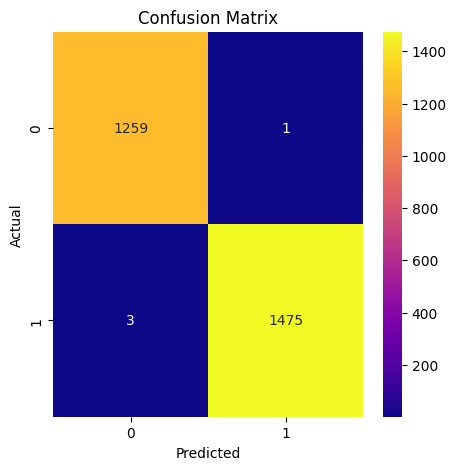

In [29]:
# confusion matrix
cm = best_model["cm"]
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, cmap="plasma", fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


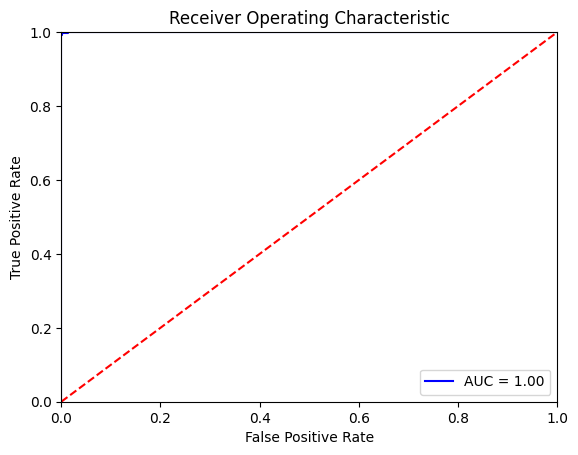

In [30]:
import sklearn.metrics as metrics
best_model = best_model['model']

probs = best_model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# plot the ROC curve
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()